# 2.0.0: Model performance


Let's take a look at how our different models perform. There are quite a few models to compare, so there are a few ways we can visualize and assess performance.

For instance, we trained models for each of 33 traits for 3 "trait sets" (i.e. the provenance of the gridded trait data: sPlot-only, GBIF-only, and sPlot + GBIF combined). Below we will explore both general, trait set-level trends as well as zoom in on 8 traits specifically to assess trait-level trends.


## Imports and config


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import font_manager

from src.conf.conf import get_config
from src.conf.environment import log
from src.utils.dataset_utils import get_latest_run, get_models_dir
from src.utils.trait_utils import get_trait_name_from_id

cfg = get_config()


font_path = "/usr/share/fonts/opentype/freefont/FreeSans.otf"
font_bold_path = "/usr/share/fonts/opentype/freefont/FreeSansBold.otf"
font_manager.fontManager.addfont(font_path)
font_manager.fontManager.addfont(font_bold_path)
plt.rcParams["font.family"] = "FreeSans"

## Model performance across all traits and trait sets at $0.01\degree$


Load combined results across all runs.


In [46]:
all_results = pd.read_parquet("results/all_results.parquet")
# Replace each trait_id with its corresponding trait name using a dictionary
trait_id_to_name = {
    trait_id: get_trait_name_from_id(trait_id)[0]
    for trait_id in all_results.trait_id.unique()
}

trait_set_to_ID = {"splot": "SCI", "splot_gbif": "COMB", "gbif": "CIT"}
all_results["trait_name"] = all_results.trait_id.map(trait_id_to_name)
all_results["trait_set_id"] = all_results.trait_set.map(trait_set_to_ID)
all_results.head()

pft resolution   trait_id   trait_set  automl model_arch  \
0  Shrub_Tree_Grass        001  X163_mean       splot    True        GBM   
1  Shrub_Tree_Grass        001  X163_mean       splot    True        GBM   
2  Shrub_Tree_Grass        001  X163_mean        gbif    True        GBM   
3  Shrub_Tree_Grass        001  X163_mean        gbif    True        GBM   
4  Shrub_Tree_Grass        001  X163_mean  splot_gbif    True        GBM   

            run_id        r2  pearsonr  pearsonr_wt  root_mean_squared_error  \
0  20240827_032644  0.168091  0.414057     0.440022                 0.367905   
1  20240827_032644  0.233690  0.503460     0.525381                 0.188455   
2  20240827_032644 -0.082184  0.288847     0.308069                 0.419613   
3  20240827_032644 -0.216775  0.360967     0.375796                 0.242961   
4  20240827_032644  0.135023  0.393680     0.418676                 0.375146   

   norm_root_mean_squared_error  mean_squared_error  mean_absolute_error  \
0                      0.211601            0.135354             0.204053   
1                      0.193087            0.035515             0.134164   
2                      0.241340            0.176075             0.290659   
3                      0.243514            0.059030             0.196692   
4                      0.215765            0.140734             0.224991   

   median_absolute_error transform       aoa       trait_name trait_set_id  
0               0.141102      none  0.905965  Leaf fresh mass          SCI  
1               0.103798       log  0.905965  Leaf fresh mass          SCI  
2               0.239805      none       NaN  Leaf fresh mass          CIT  
3               0.175843       log       NaN  Leaf fresh mass          CIT  
4               0.168629      none  0.993581  Leaf fresh mass         COMB

Let's select only the 1 km runs.


In [48]:
res_1km = all_results.query("resolution == '1km' and trait_id != 'X11_mean'")
res_1km.head()

pft resolution    trait_id   trait_set  automl model_arch  \
990  Shrub_Tree_Grass        1km   X138_mean  splot_gbif    True        GBM   
991  Shrub_Tree_Grass        1km   X138_mean  splot_gbif    True        GBM   
992  Shrub_Tree_Grass        1km   X138_mean        gbif    True        GBM   
993  Shrub_Tree_Grass        1km   X138_mean        gbif    True        GBM   
994  Shrub_Tree_Grass        1km  X3112_mean       splot    True        GBM   

              run_id        r2  pearsonr  pearsonr_wt  \
990  20241122_230826  0.019380  0.207994          NaN   
991  20241122_230826  0.185268  0.433921          NaN   
992  20241122_230826 -0.009225  0.006805          NaN   
993  20241122_230826  0.036955  0.201485          NaN   
994  20241130_131639  0.111779  0.405932          NaN   

     root_mean_squared_error  norm_root_mean_squared_error  \
990             22203.817991                      0.493495   
991                 0.651550                      0.174187   
992             22525.335713                      0.500641   
993                 0.708376                      0.189378   
994              1239.575025                      0.216461   

     mean_squared_error  mean_absolute_error  median_absolute_error transform  \
990        4.930095e+08          2267.913694             281.084776      none   
991        4.245177e-01             0.499099               0.398027     power   
992        5.073907e+08          2388.842055             287.033449      none   
993        5.017963e-01             0.535707               0.419592     power   
994        1.536546e+06           664.207749             353.648747      none   

     aoa           trait_name trait_set_id  
990  NaN  Seed number (repr.)         COMB  
991  NaN  Seed number (repr.)         COMB  
992  NaN  Seed number (repr.)          CIT  
993  NaN  Seed number (repr.)          CIT  
994  NaN     Leaf area (3112)          SCI

Define a few helper functions to allow us to use human-readable trait names and units instead of only trait IDs as defined in the TRY database.


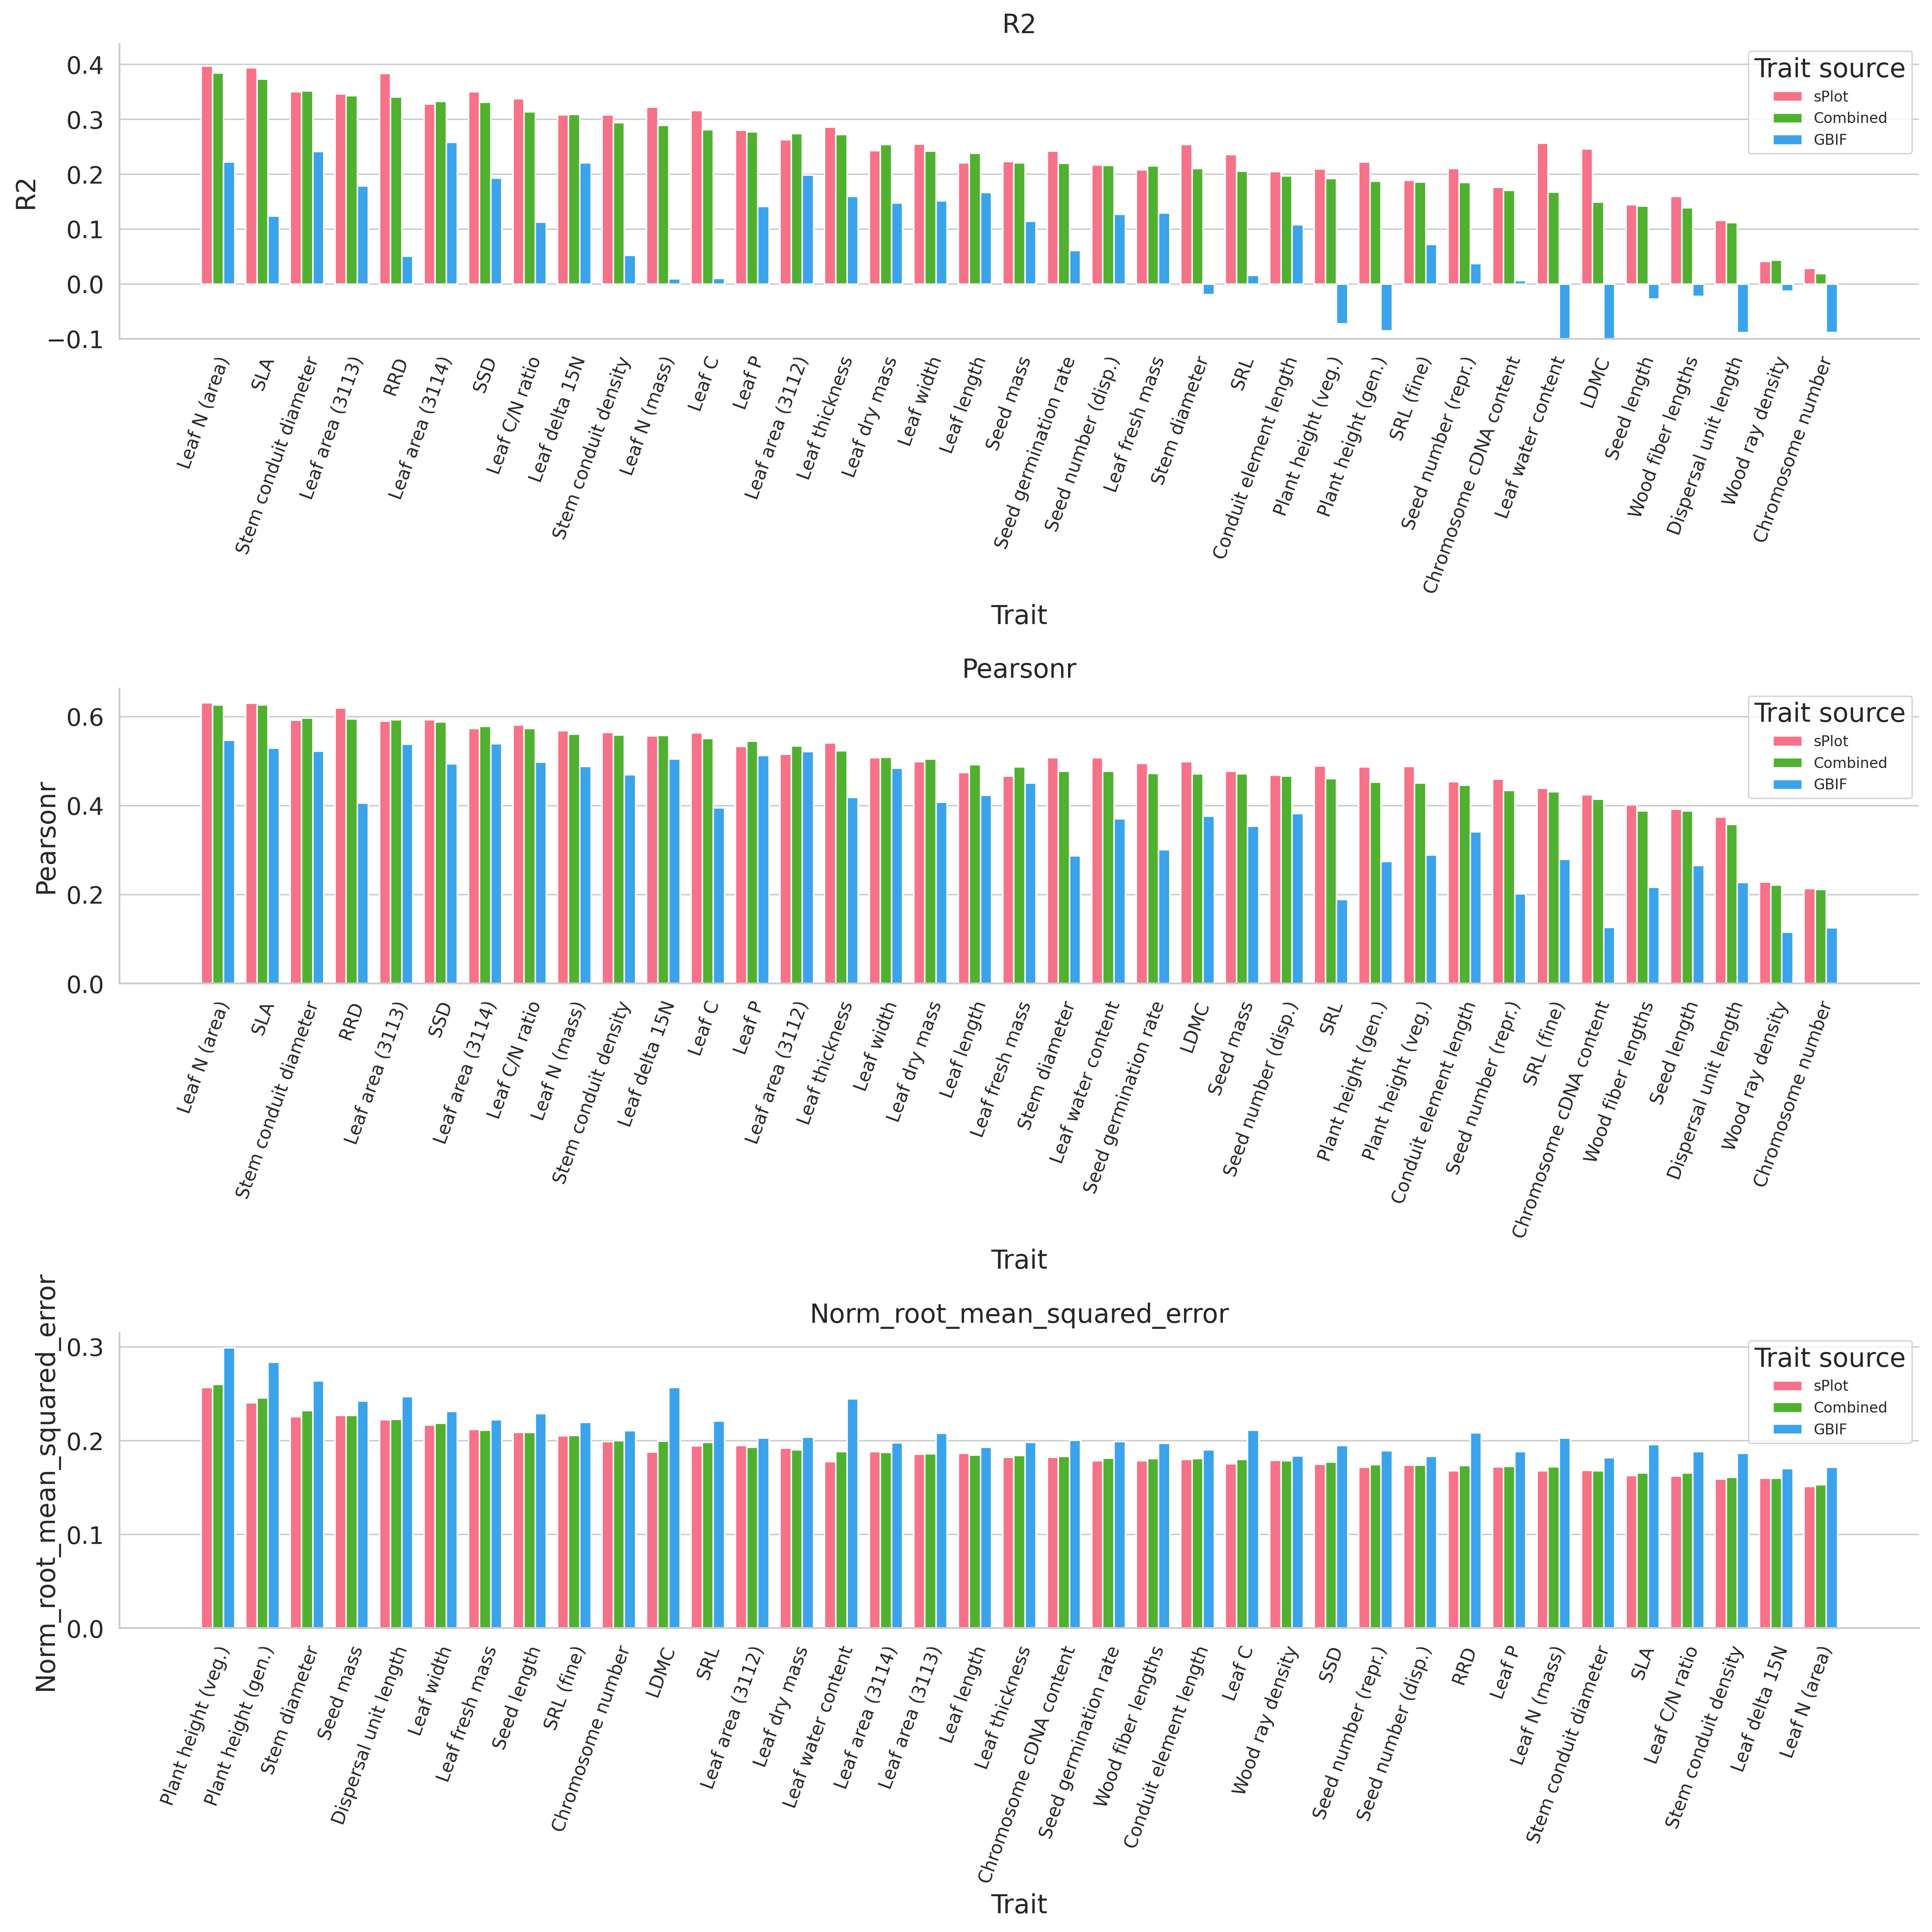

In [49]:
# Prepare data
treatments = ["splot", "splot_gbif", "gbif"]
metrics = ["r2", "pearsonr", "norm_root_mean_squared_error"]

# Set the color palette for treatments
colors = sns.color_palette("husl", len(treatments))
color_dict = dict(zip(treatments, colors))

with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    nrows = 3
    ncols = 1
    # Create subplots for each metric
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(15 * ncols, 5 * nrows), dpi=300
    )
    axs = axs.flatten()

    for idx, metric in enumerate(metrics):
        # Get traits in the order of the metric
        traits = (
            res_1km.query("trait_set == 'splot_gbif' and transform == 'power'")
            .sort_values(by=metric, ascending=False)
            .trait_id.unique()
        )
        ax = axs[idx]

        # Prepare data for the current metric
        data = []
        for trait_id in traits:
            trait_name = get_trait_name_from_id(trait_id)[0]

            for treatment in treatments:
                mean_value = res_1km.query(
                    f"trait_id == '{trait_id}' and trait_set == '{treatment}' and transform == 'power'"
                )[metric].values[0]
                std_value = np.nan

                data.append([trait_name, treatment, mean_value, std_value])

        df = pd.DataFrame(
            data, columns=["trait_name", "treatment", "mean_value", "std_value"]
        )

        # Create bar plot with error bars
        bar_width = 0.3  # Bar width
        gap = 0.3  # Gap between groups of bars
        x = np.arange(len(traits)) * (len(treatments) * bar_width + gap)

        error_kw = {
            "elinewidth": 1,  # Error bar thickness
            "ecolor": "grey",  # Error bar color
            "capsize": 2,  # Cap size for error bars
        }

        def map_treatment(treatment: str) -> str:
            if treatment == "splot":
                return "sPlot"
            if treatment == "splot_gbif":
                return "Combined"
            if treatment == "gbif":
                return "GBIF"
            else:
                raise ValueError(f"Unknown treatment {treatment}")

        for i, treatment in enumerate(treatments):
            subset = df[df["treatment"] == treatment]
            ax.bar(
                x + i * bar_width,
                subset["mean_value"],
                yerr=subset["std_value"],
                width=bar_width,
                label=map_treatment(treatment),
                color=color_dict[treatment],
                error_kw=error_kw,
            )

        ax.set_title(f"{metric.capitalize()}")
        ax.set_xlabel("Trait")
        ax.set_ylabel(metric.capitalize())
        ax.set_xticks(
            (x + bar_width * (len(treatments) - 1) / 2) - 0.05,
            [get_trait_name_from_id(t)[0] for t in traits],
            rotation=70,
            ha="right",
            va="top",
            rotation_mode="anchor",
            fontsize=10,
        )
        # ax.set_xticklabels([get_trait_name_from_id(t)[0] for t in traits], rotation=90)
        ax.legend(title="Trait source", fontsize=8)

        # Set y-axis limits for R²
        if metric == "r2":
            ax.set_ylim(-0.1)

        sns.despine()
        ax.grid(False, axis="x")

    plt.tight_layout()
    plt.show()

### Scatterplots of observed vs predicted


In [ ]:
trait_ids = res_1km.trait_id.unique()
trait_set_ids = res_1km.trait_set.unique()

In [ ]:
import scipy


def plot_observed_vs_predicted(
    ax: plt.Axes,
    observed: pd.Series,
    predicted: pd.Series,
    name: str,
    name_color: str = "black",
    log: bool = False,
    density: bool = False,
    stats: dict = {},
    show_x_label: bool = True,
    show_y_label: bool = True,
):
    """Plot observed vs. predicted values."""

    # plot the observed vs. predicted values using seaborn
    # sns.set_theme()

    p1 = min(predicted.min(), observed.min())
    p2 = max(predicted.max(), observed.max())

    cmap = sns.cubehelix_palette(start=0.5, rot=-0.75, reverse=True, as_cmap=True)  # type: ignore
    if density:
        sns.kdeplot(
            x=predicted, y=observed, ax=ax, cmap=cmap, fill=False, thresh=0.0075
        )
    else:
        sns.scatterplot(x=predicted, y=observed, ax=ax, s=1, alpha=0.01, edgecolor=None)

    # Fit a regression line for observed vs. predicted values, plot the regression
    # line so that it spans the entire plot, and print the correlation coefficient
    # Get m and b using scipy.stats.lingress

    m, b = scipy.stats.linregress(predicted, observed)[:2]
    reg_line = [m * p1 + b, m * p2 + b]

    if log:
        ax.loglog([p1, p2], [p1, p2], color="black", ls="-.", lw=0.5, alpha=0.5)
        ax.loglog([p1, p2], reg_line, color="red", lw=0.5)
    else:
        ax.plot([p1, p2], [p1, p2], color="black", ls="-.", lw=0.5, alpha=0.5)
        ax.plot([p1, p2], reg_line, color="red", lw=0.5)

    # make sure lines are positioned on top of kdeplot
    ax.set_zorder(1)

    if stats:
        for i, (key, value) in enumerate(stats.items()):
            ax.text(
                0.05,
                0.95 - i * 0.1,
                f"{key} = {value:.3f}",
                transform=ax.transAxes,
                ha="left",
                va="top",
            )

    # include legend items for the reg_line and the 1-to-1 line
    ax.legend(
        [
            ax.get_lines()[0],
            ax.get_lines()[1],
        ],
        ["1-to-1", "Regression"],
        loc="lower right",
        frameon=False,
    )

    # set informative axes and title
    if show_x_label:
        ax.set_xlabel("Predicted")
    else:
        ax.set_xlabel("")
    if show_y_label:
        ax.set_ylabel("Observed")
    else:
        ax.set_ylabel("")
    ax.set_title(name, color=name_color)

    return ax

In [ ]:
import warnings

import matplotlib.gridspec as gridspec

warnings.filterwarnings("ignore")

traits = [d for d in Path("results/Shrub_Tree_Grass/001").glob("*") if d.is_dir()]
ts = ["splot", "splot_gbif", "gbif"]
m = len(traits)
n = len(ts)
# Create the main GridSpec
fig = plt.figure(figsize=(n * 6, m * 4), dpi=200)
outer_grid = gridspec.GridSpec(m, n, wspace=0.2, hspace=0.7)

trait_set_cmap = {"splot": "red", "splot_gbif": "green", "gbif": "blue"}

trait_set_names = {"splot": "sPlot", "splot_gbif": "Combined", "gbif": "GBIF"}

with sns.plotting_context("paper", font_scale=1), sns.axes_style("ticks"):
    for i, trait_dir in enumerate(traits):
        trait_id = trait_dir.name
        for j, trait_set_id in enumerate(ts):
            # Create a nested GridSpec for each cell in the main grid
            inner_grid = gridspec.GridSpecFromSubplotSpec(
                1, 2, subplot_spec=outer_grid[i, j], hspace=0.1
            )

            results_dir = get_latest_run(trait_dir / trait_set_id)

            desired_stats = ["r2", "pearsonr", "norm_root_mean_squared_error"]
            col_map = {
                "r2": "R²",
                "pearsonr": "$r$",
                "norm_root_mean_squared_error": "nRMSE",
            }

            stats = (
                res_1km.query(
                    f"trait_id == '{trait_id}' and trait_set == '{trait_set_id}' and transform == 'none'"
                )[desired_stats]
                .rename(columns=col_map)
                .to_dict(orient="records")[0]
            )
            stats_ln = (
                res_1km.query(
                    f"trait_id == '{trait_id}' and trait_set == '{trait_set_id}' and transform == 'log'"
                )[desired_stats]
                .rename(columns=col_map)
                .to_dict(orient="records")[0]
            )

            obs_vs_pred = pd.read_parquet(
                results_dir / "cv_obs_vs_pred.parquet"
            ).sample(frac=0.1)

            scale = min(obs_vs_pred["obs"].min(), obs_vs_pred["pred"].min())
            obs_vs_pred_ln = np.log1p(obs_vs_pred[["obs", "pred"]] + abs(scale))

            # Create the first subsubplot
            ax1 = plt.Subplot(fig, inner_grid[0])
            fig.add_subplot(ax1)

            plot_observed_vs_predicted(
                ax1,
                obs_vs_pred["obs"],
                obs_vs_pred["pred"],
                f"{trait_set_names[trait_set_id]}",
                name_color=trait_set_cmap[trait_set_id],
                log=False,
                density=False,
                stats=stats,
                show_y_label=True,
            )

            # Create the second subsubplot
            ax2 = plt.Subplot(fig, inner_grid[1])
            fig.add_subplot(ax2)

            plot_observed_vs_predicted(
                ax2,
                obs_vs_pred_ln["obs"],
                obs_vs_pred_ln["pred"],
                f"{trait_set_names[trait_set_id]} (log)",
                name_color=trait_set_cmap[trait_set_id],
                log=True,
                density=False,
                stats=stats_ln,
                show_y_label=False,
            )

            # For each row in the outer_grid, set a title corresponding to the trait name.
            # The title should be centered above the subplots in the row. The title should
            # not be tied to a specific axis.
            if j == 1:
                ax1.annotate(
                    get_trait_name_from_id(trait_id)[0],
                    xy=(0.5, 1.2),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha="center",
                    va="baseline",
                    fontsize=12,
                    color="black",
                    weight="bold",
                    xycoords="axes fraction",
                )

    sns.despine()
    plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 3600x0 with 0 Axes>

### Violin plots aggregating all traits for each trait set


Compare log-transformed and untransformed metrics.


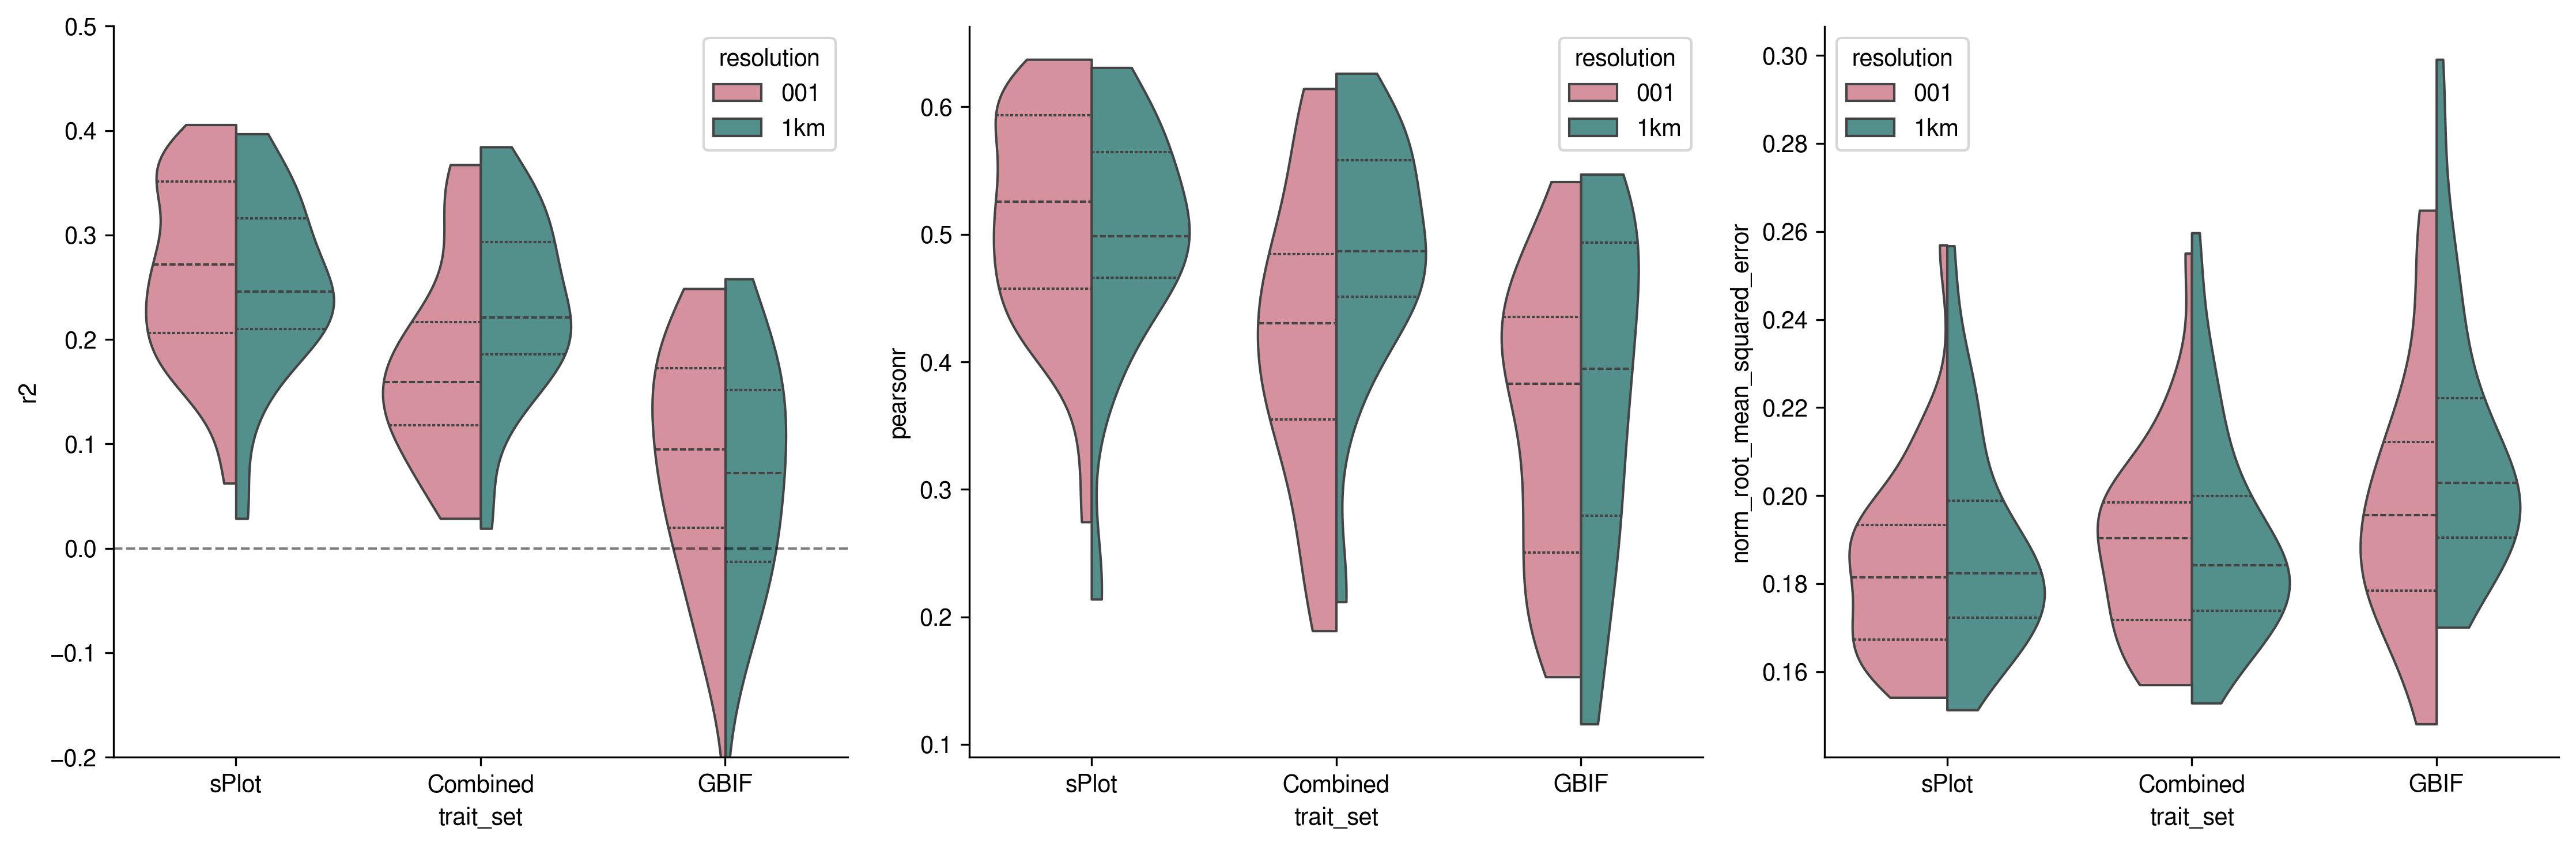

In [6]:
# Reset index to convert MultiIndex to columns
metrics = ["r2", "pearsonr", "norm_root_mean_squared_error"]
fig, axs = plt.subplots(nrows=1, ncols=3, dpi=300, figsize=(3 * 5, 5))

custom_order = ["splot", "splot_gbif", "gbif"]
custom_labels = ["sPlot", "Combined", "GBIF"]
plot_data = all_results.query(
    "(resolution == '1km' and transform == 'power') or (resolution == '001' and transform == 'none')"
)

for idx, metric in enumerate(metrics):
    ax = axs.flatten()[idx]
    # df_metric = df_long[["trait_id", "trait_set", "agg", metric]]
    df_metric = plot_data[["trait_id", "trait_set", metric, "resolution"]]
    df_metric = df_metric.sort_values(by="trait_set", ascending=False)

    if metric == "r2":
        # add a horizontal line at 0
        ax.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.5)
        ax.set_ylim(-0.2, 0.5)

    # Plot the mean values
    sns.violinplot(
        x="trait_set",
        y=metric,
        data=df_metric,
        hue="resolution",
        split=True,
        ax=ax,
        inner="quart",
        # color="skyblue",
        linewidth=1,
        order=custom_order,
        palette="husl",
        # dodge=True
        cut=0,
        saturation=0.5,
        # inner_kws={"linewidth": 3, "alpha": 0.2},
    )

    ax.set_xticks(ax.get_xticks(), custom_labels)
    # ax.legend(frameon=False)
    sns.despine()

# data = res_1km.query("transform == 'none'")[["trait_id", "trait_set", "r2"]]

# # Replace each trait_id with its corresponding trait name (from get_trait_name_from_id)
# # Create a dictionary to map trait_id to trait_name
# trait_id_to_name = {
#     trait_id: get_trait_name_from_id(trait_id)[0] for trait_id in data.trait_id.unique()
# }

# # Replace each trait_id with its corresponding trait name using the dictionary
# data["trait_name"] = data.trait_id.map(trait_id_to_name)

# data = data.drop(columns=["trait_id"]).sort_values(["trait_name", "r2"])
# # data = data.drop(columns=["trait_id"]).pivot_table(
#     index="trait_name", columns="trait_set", values="r2"
# )

# sorted_cols = data.apply(lambda row: row.sort_values(ascending=True).index, axis=1)
# data = data.apply(lambda row: row.sort_values(ascending=True), axis=1,)
# data.columns = sorted_cols.iloc[0]
# data = data[sorted_cols.iloc[0]]

# unique_trait_sets = data.trait_set.unique()
# # colors = sns.color_palette("husl", n_colors=len(data.columns), desat=0.5)
# colors = dict(
#     zip(
#         unique_trait_sets,
#         sns.color_palette("husl", n_colors=len(unique_trait_sets), desat=0.5),
#     )
# )
# fig, ax = plt.subplots(figsize=(10, 10))


# # for i, col in enumerate(data.columns):
# #     bottom = pd.Series(0, index=data.index)
# #     ax.bar(
# #         data.index,
# #         data[col],
# #         bottom=bottom,
# #         label=col,
# #         color=colors[i],
# #     )
# #     bottom += data[col]

# for trait_name, g in data.groupby("trait_name"):
#     # if g.r2.min() < 0:
#     #     bottom = g.r2.min()
#     #     top = 0
#     # else:
#     #     bottom = 0
#     #     top = None

#     i = 0
#     top = None
#     for _, row in g.iterrows():
#         if row.r2 < 0 and i == 0:
#             bottom = row.r2
#             top = 0
#         elif row.r2 < 0 and i > 0:
#             bottom = row.r2
#             top = 0

#         if top is None:
#             bottom = 0
#             top = row.r2

#         if i > 0:
#             top = row.r2

#         ax.bar(
#             trait_name,
#             top,
#             bottom=bottom,
#             label=trait_name if bottom == g.r2.min() else None,
#             color=colors[row.trait_set],
#         )
#         bottom = top

#         i += 1


# plt.xlabel("Trait")
# plt.ylabel("R2")
# # plt.legend(title="Trait set")
# plt.title("R2 by trait and trait set")
# plt.xticks(rotation=90)
# plt.tight_layout()

# plt.show()

plt.tight_layout()
plt.show()

Only look at untransformed performance across trait sets.


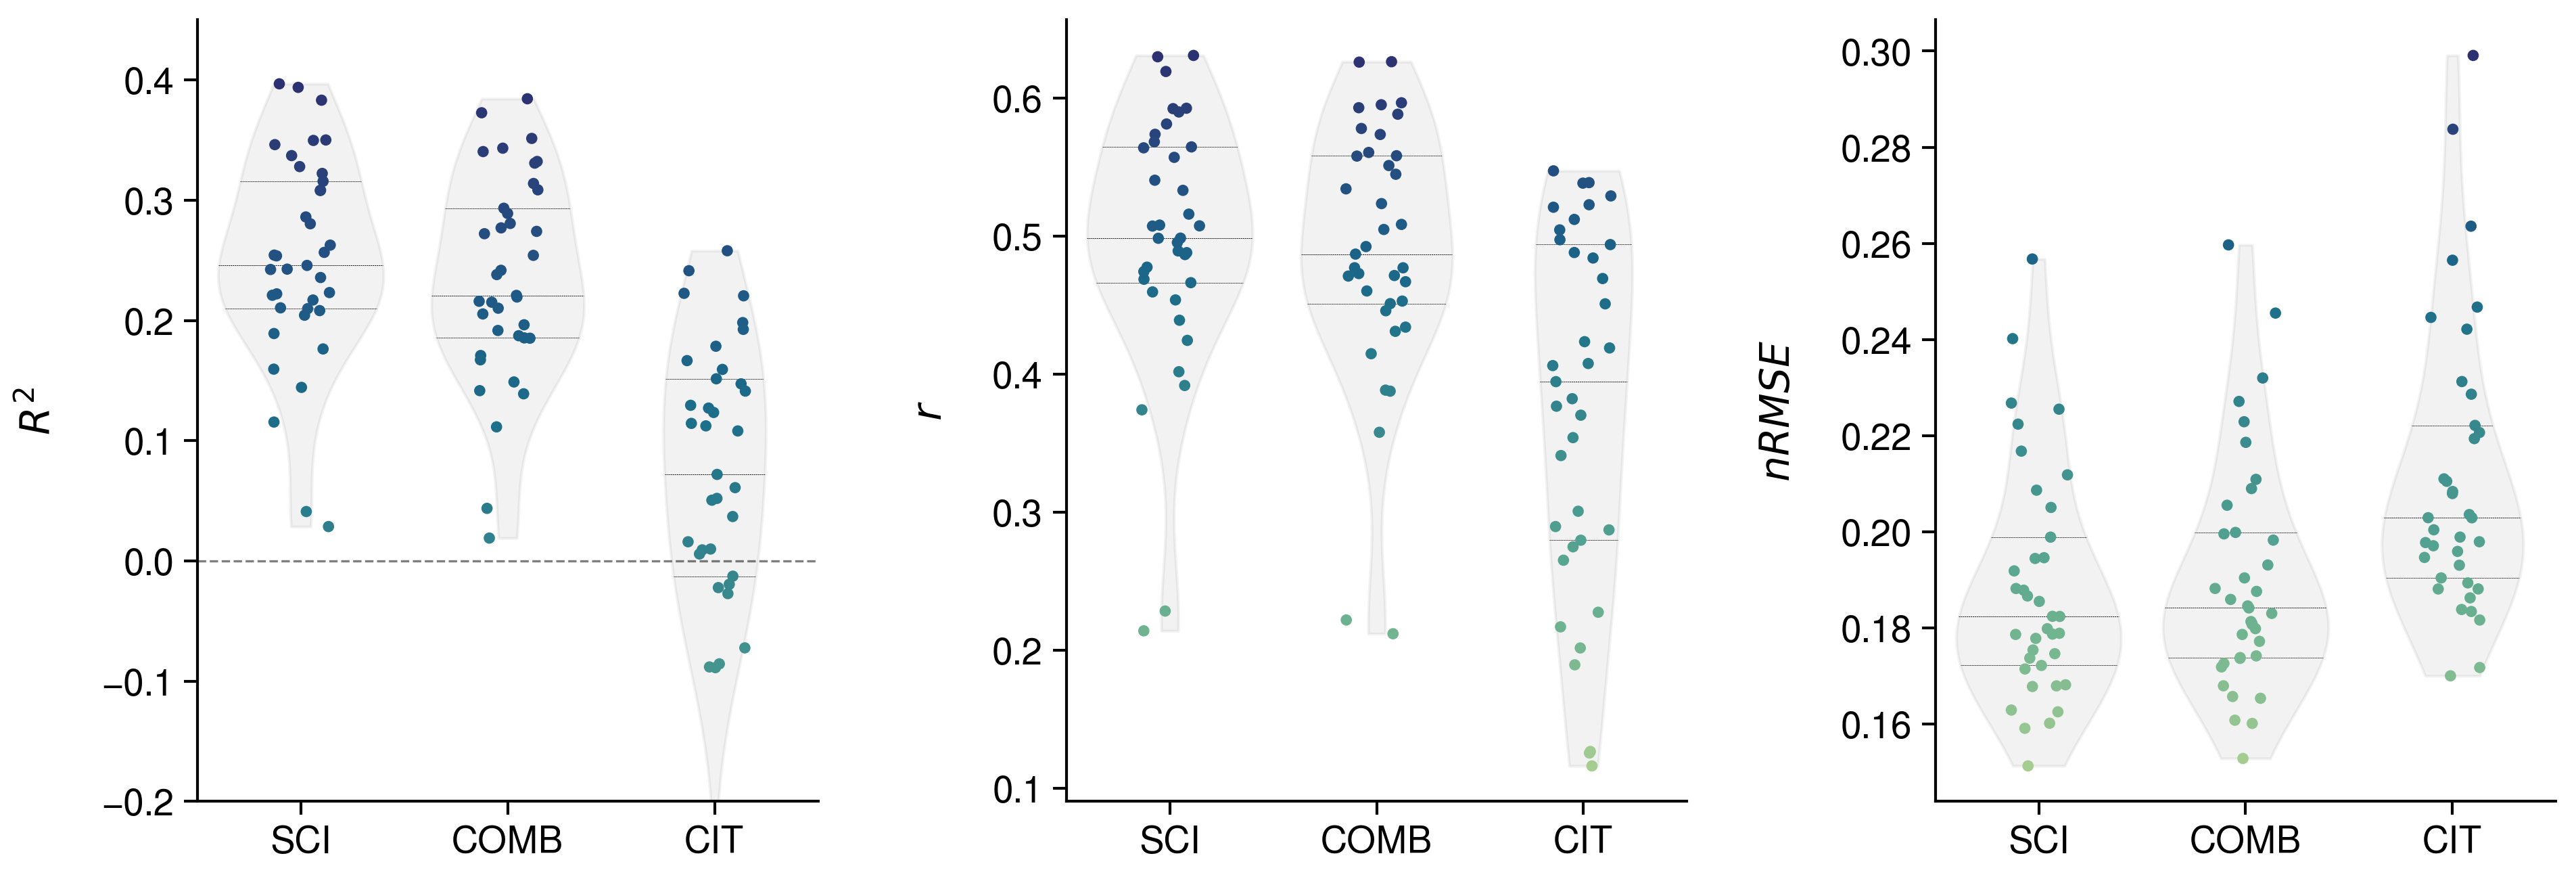

In [9]:
SAVE = True

metrics = ["r2", "pearsonr", "norm_root_mean_squared_error"]

custom_order = ["splot", "splot_gbif", "gbif"]
custom_labels = ["SCI", "COMB", "CIT"]
metric_labels = ["$R^2$", "$r$", "$nRMSE$"]

with sns.plotting_context("paper", font_scale=1.5):
    fig, axs = plt.subplots(nrows=1, ncols=3, dpi=300, figsize=(3 * 5, 5))
    for idx, metric in enumerate(metrics):
        ax = axs.flatten()[idx]
        # df_metric = df_long[["trait_id", "trait_set", "agg", metric]]
        df_metric = res_1km[["trait_id", "trait_set", metric, "transform"]].query(
            "transform == 'power'"
        )
        df_metric = df_metric.rename(columns={metric: metric_labels[idx]})
        df_metric = df_metric.sort_values(by="trait_set", ascending=False)
        metric = metric_labels[idx]
        if metric == "$R^2$":
            # add a horizontal line at 0
            ax.axhline(0, color="black", linestyle="--", linewidth=0.8, alpha=0.5)
            ax.set_ylim(-0.2, 0.45)

        # Plot the mean values
        sns.violinplot(
            x="trait_set",
            y=metric,
            data=df_metric,
            ax=ax,
            inner="quart",
            linewidth=1,
            order=custom_order,
            # palette="husl",
            cut=0,
            saturation=0.5,
            color="black",
            alpha=0.05,
            inner_kws={"linewidth": 0.2, "alpha": 1},
        )

        # Add inner points colored by their y value
        sns.stripplot(
            x="trait_set",
            y=metric,
            data=df_metric,
            ax=ax,
            palette="crest",
            hue=metric,
            order=custom_order,
            size=4,
            jitter=0.15,
            linewidth=0,
        )

        ax.set_ylabel(metric, labelpad=15)
        # ax.set_ylabel(metric_labels[idx])
        ax.set_xlabel("")
        ax.legend().remove()
        ax.set_xticks(ax.get_xticks(), custom_labels)
        # ax.legend(frameon=False)
        sns.despine()

    plt.subplots_adjust(wspace=0.4)

    if SAVE:
        plt.savefig(
            "results/figures/model-perf-trait-sets.png", dpi=300, bbox_inches="tight"
        )

In [ ]:
median_values = (
    res_1km.query("transform == 'none'")
    .groupby("trait_set")[metrics]
    .agg(["mean", "median", "std", "max", "min"])
)
median_values

r2                                         pearsonr_wt  \
                mean    median       std       max       min        mean   
trait_set                                                                  
gbif        0.078038  0.094911  0.137299  0.248642 -0.446095    0.355789   
splot       0.264971  0.272000  0.088836  0.405653  0.062355    0.514924   
splot_gbif  0.176985  0.159426  0.097549  0.367329  0.028602    0.422274   

                                                    \
              median       std       max       min   
trait_set                                            
gbif        0.394558  0.116522  0.552563  0.154413   
splot       0.519534  0.087247  0.632900  0.277659   
splot_gbif  0.440881  0.122354  0.622571  0.192602   

           norm_root_mean_squared_error                                \
                                   mean    median       std       max   
trait_set                                                               
gbif                           0.199164  0.195511  0.030379  0.264801   
splot                          0.183493  0.181456  0.021649  0.256902   
splot_gbif                     0.187978  0.190321  0.021990  0.255043   

                      
                 min  
trait_set             
gbif        0.148099  
splot       0.154134  
splot_gbif  0.156989

### Visualize Pearson's $r$ across trait sets for all traits at 1 km resolution


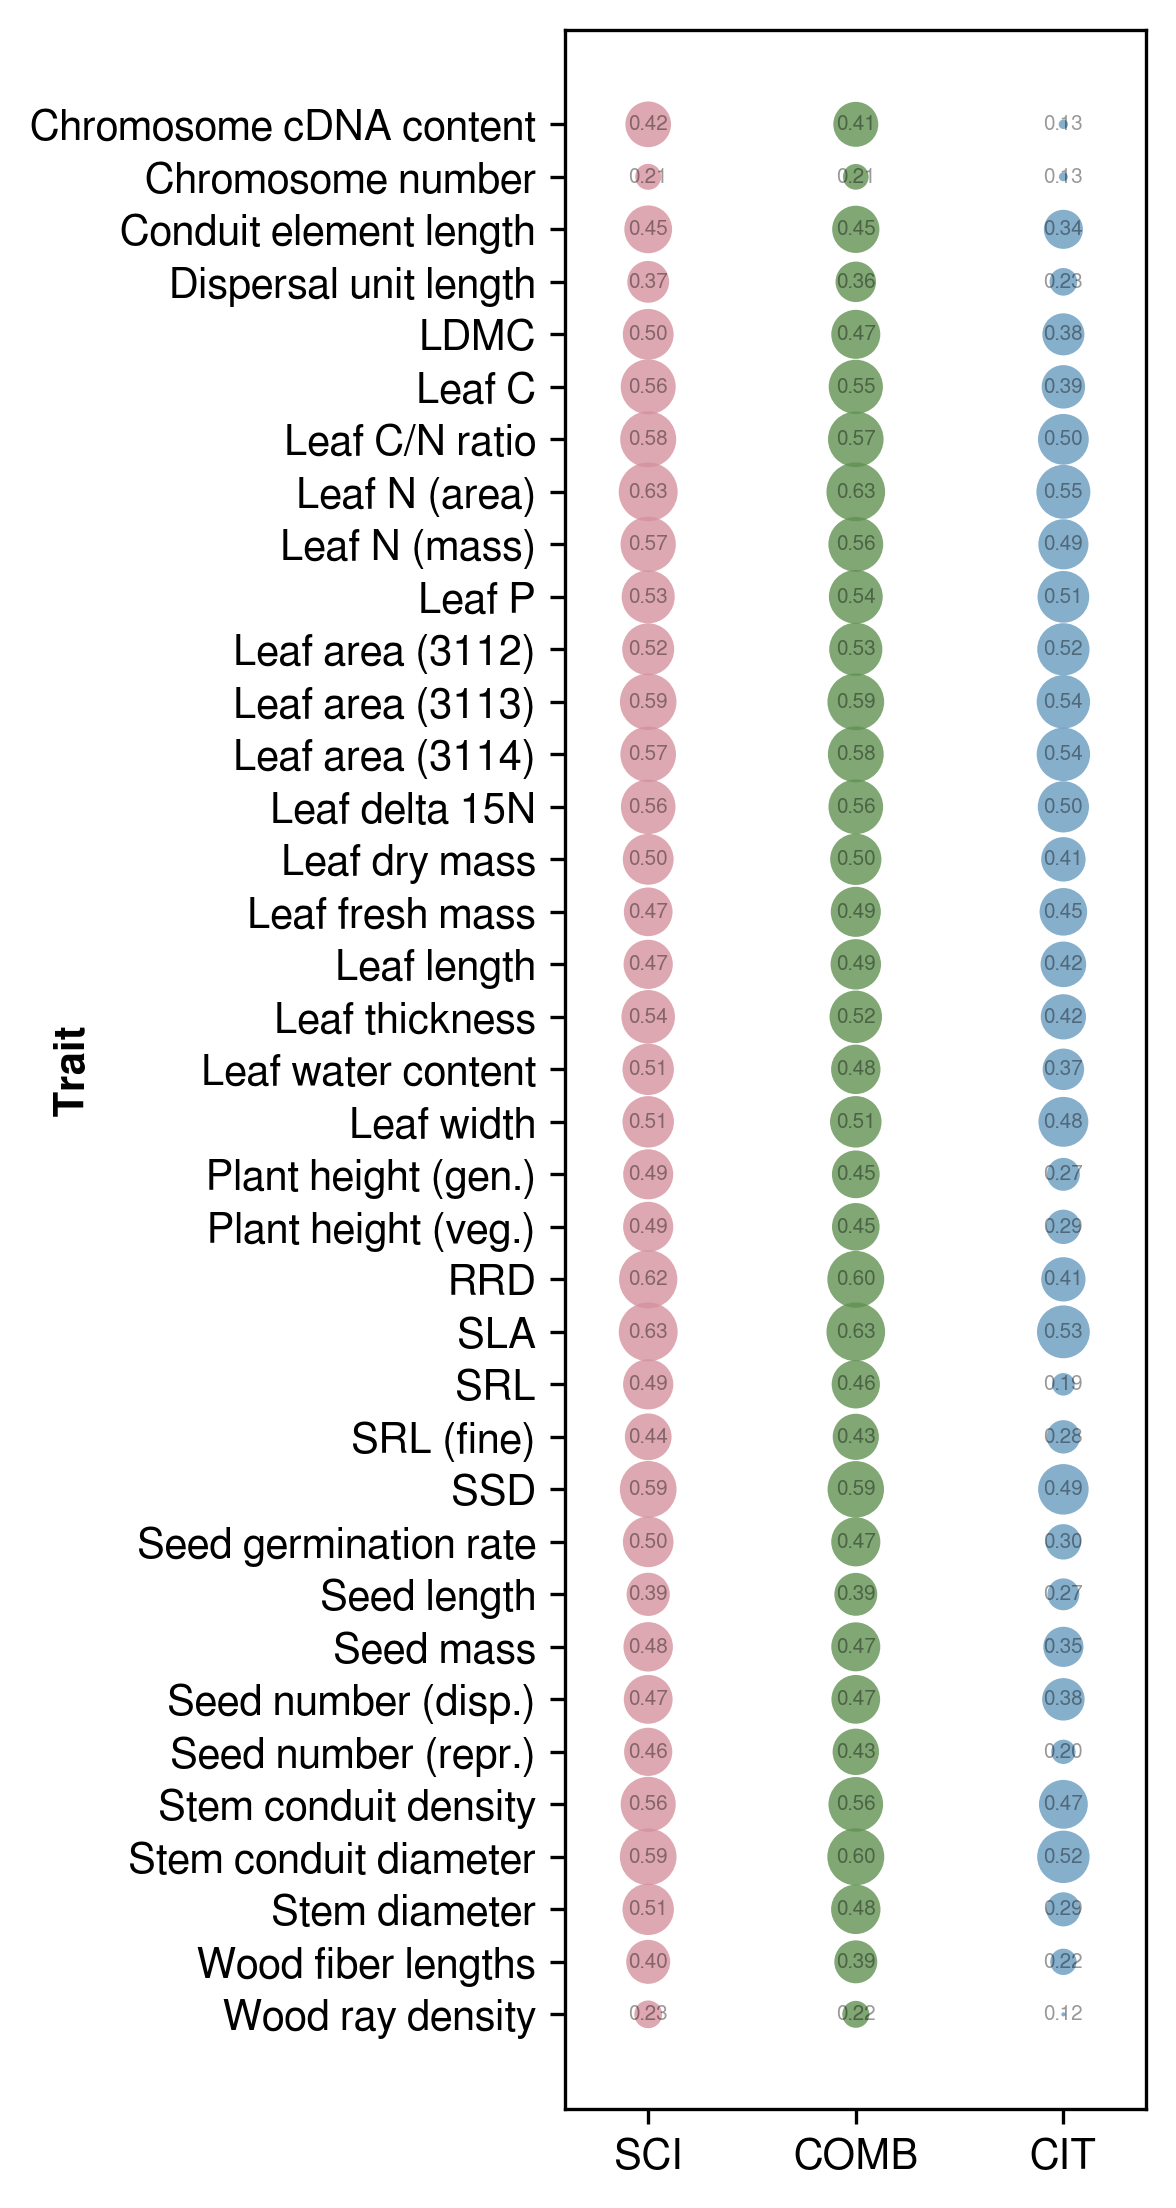

In [13]:
SAVE = True

# Filter the data for transform == 'none'
heatmap_data = res_1km.query("transform == 'power'").copy()
heatmap_data.trait_id = heatmap_data.trait_id.apply(get_trait_name_from_id)
heatmap_data.trait_id = heatmap_data.trait_id.apply(lambda x: x[0])
trait_set_labels = ["SCI", "COMB", "CIT"]
trait_set_vals = ["splot", "splot_gbif", "gbif"]
heatmap_data["trait_set"] = heatmap_data["trait_set"].map(
    dict(zip(trait_set_vals, trait_set_labels))
)

# Pivot the data to get the desired format for the heatmap
heatmap_data_pivot = heatmap_data.pivot(
    index="trait_id", columns="trait_set", values="pearsonr"
)

# Reorder the columns
heatmap_data_pivot = heatmap_data_pivot[trait_set_labels]

# Create a scatter plot with circles representing the magnitude of pearsonr values
plt.figure(figsize=(2.5, 9), dpi=300)
palette = sns.color_palette("husl", n_colors=len(trait_set_labels), desat=0.5)
scatter_data = heatmap_data_pivot.reset_index().melt(
    id_vars="trait_id", var_name="Trait Set", value_name="pearsonr"
)
sns.scatterplot(
    data=scatter_data,
    x="Trait Set",
    y="trait_id",
    hue="Trait Set",
    palette=palette,
    size="pearsonr",
    sizes=(1, 200),
    alpha=0.8,
    legend=False,
    linewidth=0,
)

# Add r value inside each circle
for _, row in scatter_data.iterrows():
    plt.text(
        row["Trait Set"],
        row["trait_id"],
        f"{row['pearsonr']:.2f}",
        ha="center",
        va="center",
        fontsize=5,
        color="black",
        alpha=0.4,
    )

# Add padding between the left vertical border and the first x tick and the right vertical border and the last x tick
plt.gca().margins(x=0.2)
plt.xlabel("")
plt.ylabel("Trait", labelpad=-15, fontweight="bold")
# plt.title("Pearson's r values represented by circle sizes")

if SAVE:
    plt.savefig("results/figures/pearsonr-circles.png", dpi=300, bbox_inches="tight")

plt.show()

Let's look at just the sPlot+GBIF Pearson's $r$ top performers.


In [16]:
pd.set_option("display.max_rows", None)
res_1km.query("transform == 'power' and trait_set == 'splot_gbif'")[
    ["trait_name", "pearsonr", "trait_set_id"]
].sort_values("pearsonr", ascending=False)

trait_name  pearsonr trait_set_id
250            Leaf N (area)  0.626219         COMB
298                      SLA  0.625903         COMB
370    Stem conduit diameter  0.596451         COMB
196                      RRD  0.595019         COMB
208         Leaf area (3113)  0.592884         COMB
364                      SSD  0.588171         COMB
280         Leaf area (3114)  0.577834         COMB
244           Leaf C/N ratio  0.573486         COMB
376            Leaf N (mass)  0.560474         COMB
190     Stem conduit density  0.558094         COMB
214           Leaf delta 15N  0.557829         COMB
262                   Leaf C  0.550988         COMB
292                   Leaf P  0.544675         COMB
172         Leaf area (3112)  0.534099         COMB
202           Leaf thickness  0.523411         COMB
178               Leaf width  0.508332         COMB
382            Leaf dry mass  0.504669         COMB
346              Leaf length  0.492286         COMB
322          Leaf fresh mass  0.486822         COMB
274            Stem diameter  0.476929         COMB
220       Leaf water content  0.476901         COMB
334    Seed germination rate  0.472720         COMB
232                     LDMC  0.471311         COMB
304                Seed mass  0.470911         COMB
358      Seed number (disp.)  0.466827         COMB
286                      SRL  0.460120         COMB
256      Plant height (gen.)  0.452791         COMB
238      Plant height (veg.)  0.450947         COMB
184   Conduit element length  0.445795         COMB
166      Seed number (repr.)  0.433921         COMB
226               SRL (fine)  0.430882         COMB
328  Chromosome cDNA content  0.414673         COMB
316       Wood fiber lengths  0.388279         COMB
340              Seed length  0.387539         COMB
352    Dispersal unit length  0.357741         COMB
310         Wood ray density  0.221757         COMB
268        Chromosome number  0.211792         COMB

## Multi-resolution Pearson's $r$


In [ ]:
def convert_resolution(res_str):
    try:
        return float(res_str) / 100 if len(res_str) > 1 else float(res_str)
    except ValueError:
        raise ValueError(f"Invalid resolution string: {res_str}")


# Example usage
print(convert_resolution("001"))  # Output: 0.01
print(convert_resolution("5"))  # Output: 5.0

0.01
5.0


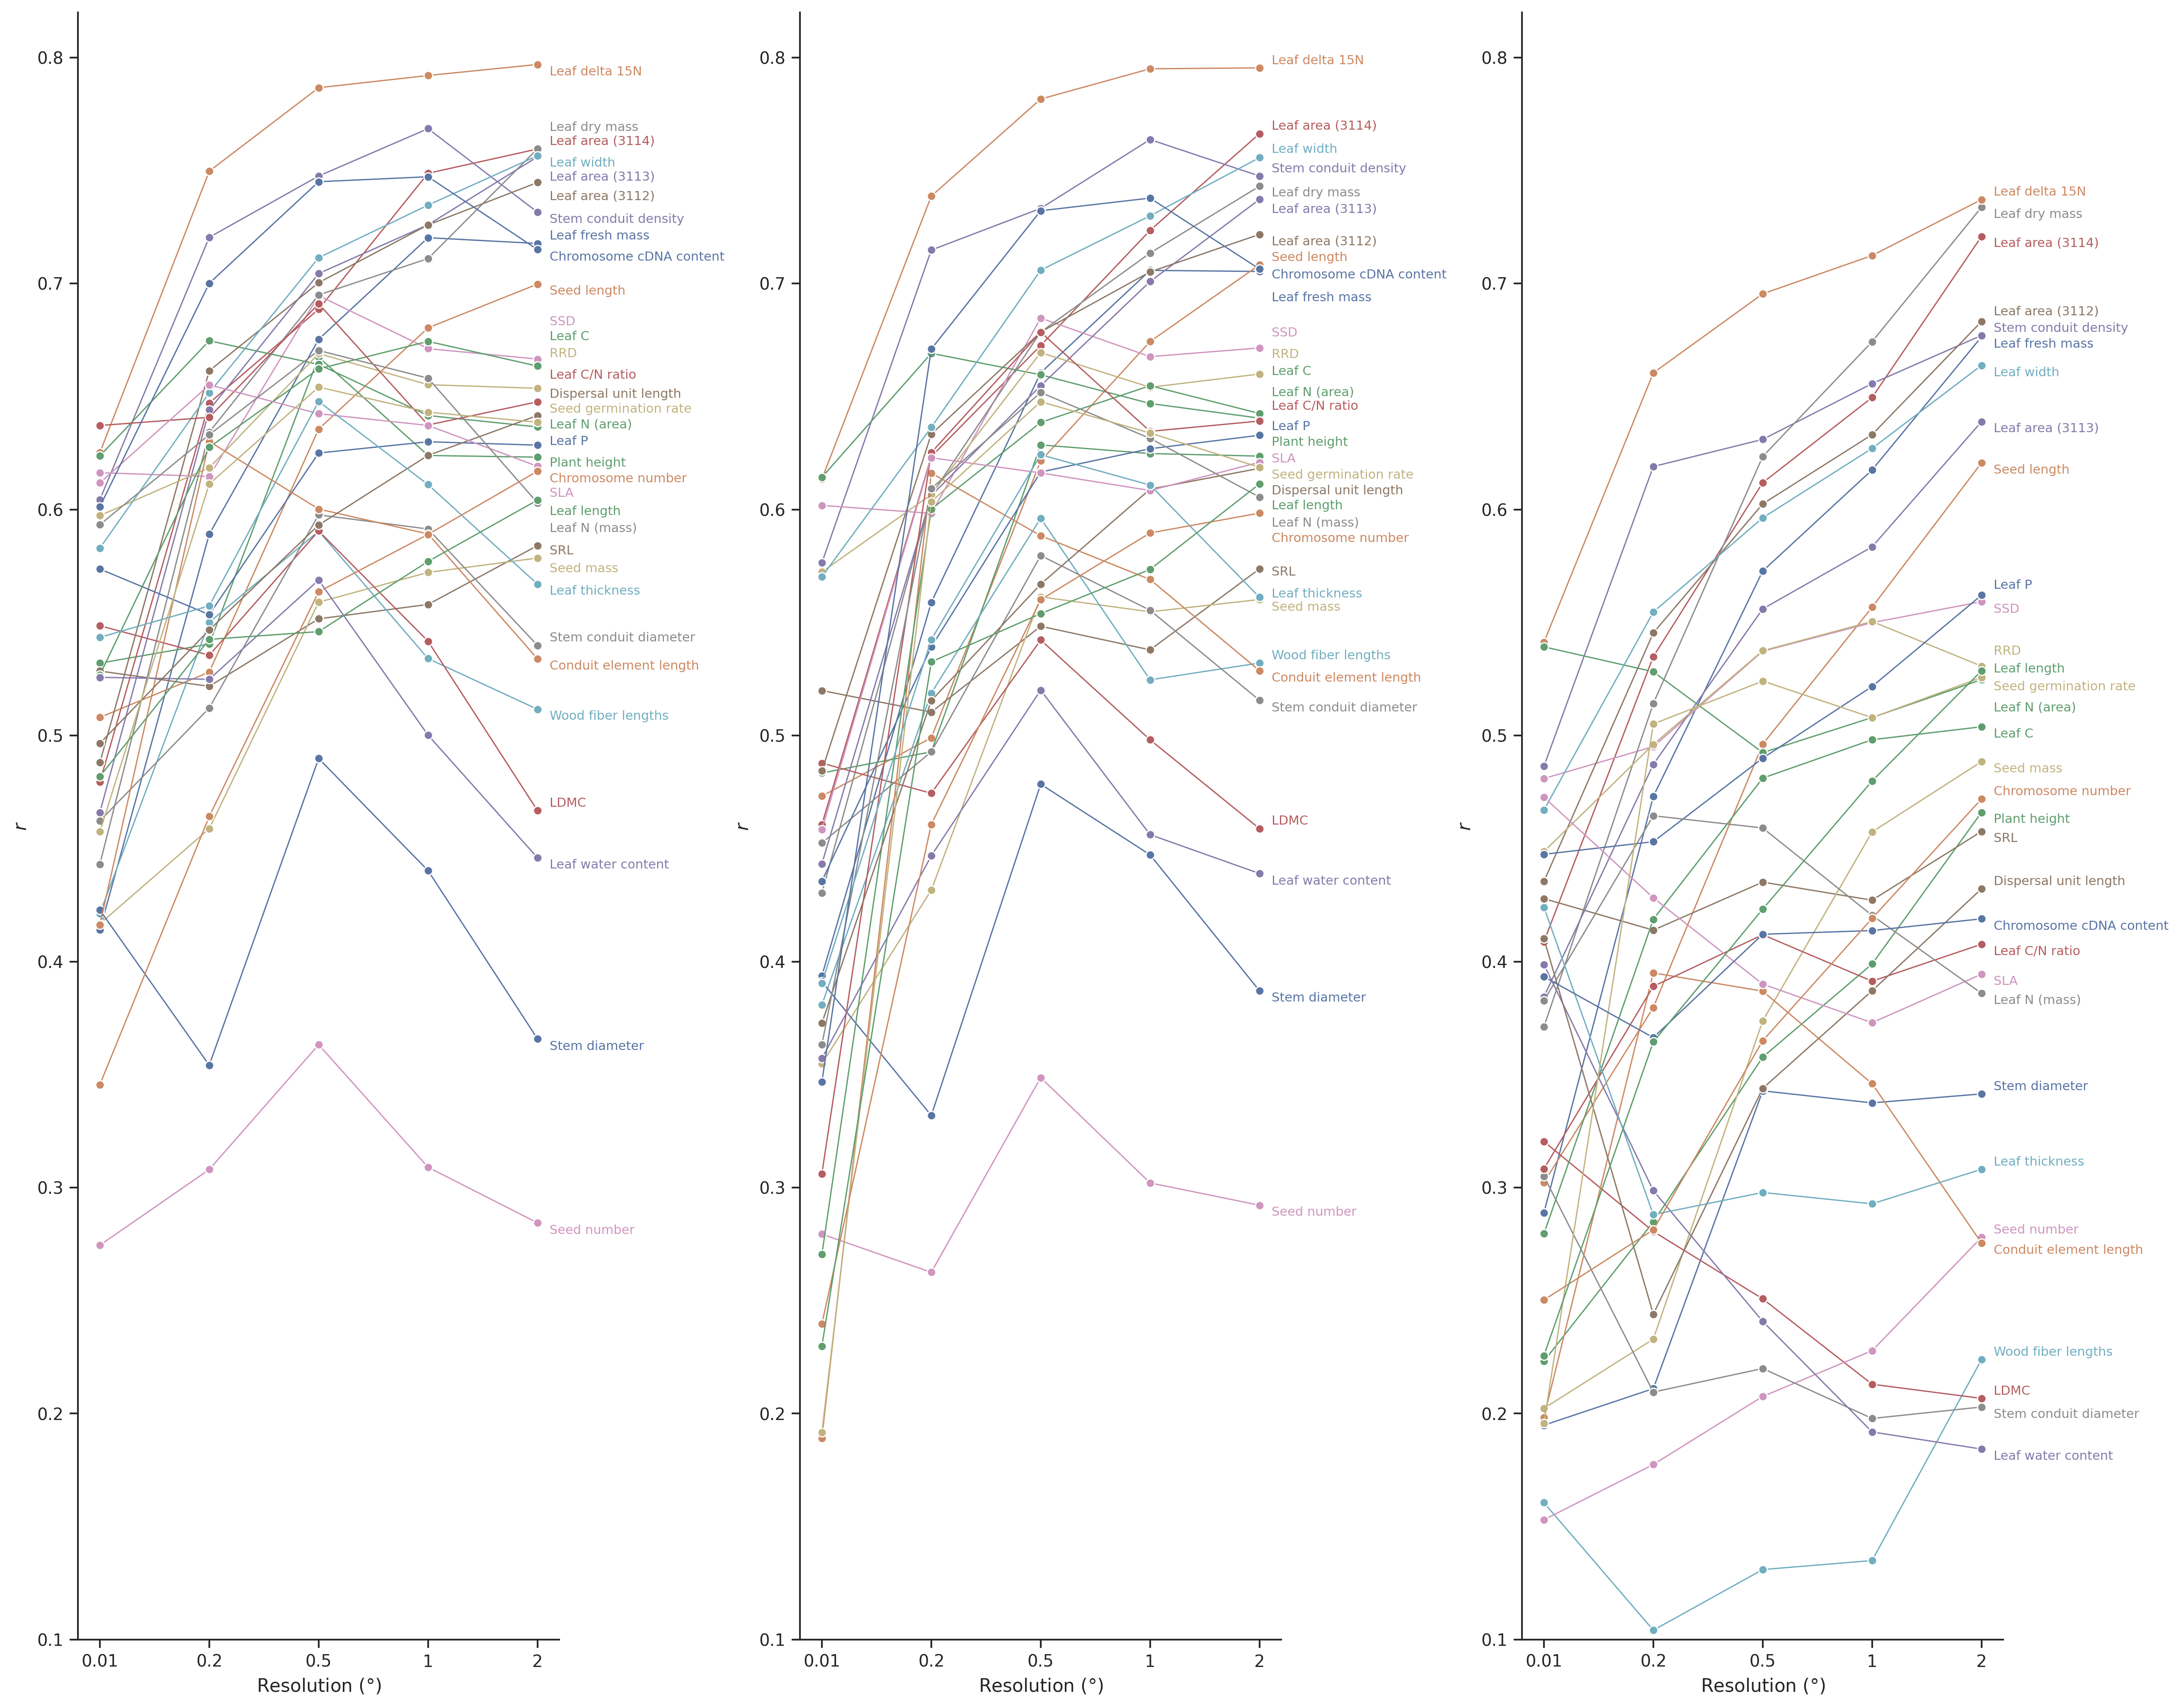

In [ ]:
from adjustText import adjust_text


def plot_splot_correlations(
    df: pd.DataFrame, pft: str, trait_set_ids: list[str], out_path: Path | None = None
):
    """Plot sPlot correlations for GBIF and sPlot extrapolations for the given PFT"""

    df = df.query(f"pft == '{pft}' " "and transform == 'none' and resolution != '1km'")[
        ["trait_id", "trait_set_id", "pearsonr", "resolution"]
    ]

    traits = df.trait_id.unique()

    resolution_labels = ["0.01", "0.2", "0.5", "1", "2"]
    resolutions = ["001", "02", "05", "1", "2"]

    # Figure directory
    nrows = 1
    ncols = len(trait_set_ids)
    _, axs = plt.subplots(
        nrows, ncols=ncols, figsize=(6.66 * ncols, 17 * nrows), dpi=300
    )
    if ncols > 1:
        axs = axs.flatten()
    else:
        axs = [axs]

    Y_LIM = (0.1, 0.82)

    for ax, trait_set_id in zip(axs, trait_set_ids):
        text_x = 0.98

        # Define colors
        # colors = plt.cm.Paired(np.linspace(0, 1, len(stg.index.get_level_values(0).unique())))
        # use sns instead (e.g. sns.hls_palette(h=.5))
        colors = sns.color_palette(n_colors=len(traits), desat=0.75)

        x_positions = [text_x] * len(traits)
        y_positions = []
        labels = []
        label_colors = []

        # Loop over each trait
        for color, trait in zip(colors, traits):
            # Select data for the current trait
            trait_data = df.query(f"trait_id == '{trait}'")
            trait_short = get_trait_name_from_id(trait)[0]

            # Plot sPlot data with solid line and circular markers
            # splot_data = trait_data.xs("sPlot", axis=0, level=1)
            ts_data = trait_data.query(f"trait_set_id == '{trait_set_id}'")
            y_positions.append(ts_data.pearsonr.values[-1])

            ax.plot(
                ts_data.resolution,
                ts_data.pearsonr,
                linestyle="-",
                color=color,
                label=f"{trait}",
                marker="o",
                markeredgecolor="white",
                markeredgewidth=0.7,
                ms=5,
                linewidth=0.75,
            )

            labels.append(trait_short)
            label_colors.append(color)

        texts = []
        for x_position, y_position, label, color in zip(
            x_positions, y_positions, labels, label_colors
        ):
            text = ax.text(
                x_position,
                y_position,
                label,
                ha="right",
                va="center",
                color=color,
                fontsize="x-small",
            )
            texts.append(text)

        # make sure the plots share the same y-axis
        if ncols > 1:
            ax.set_ylim(*Y_LIM)

        adjust_text_kwargs = {
            "force_text": (0, 0.5),
            "only_move": {"text": "y", "static": "y", "explode": "y", "pull": "y"},
        }

        adjust_text(
            texts,
            ax=ax,
            **adjust_text_kwargs,
        )

        # Readjust the x-position of the text since adjust_text doesn't seem to respect the
        # only_move parameter and still moves the text in the x-direction
        def _reset_text_x(_texts, _x_position, _ax):
            for _text in _texts:
                _text.set_ha("left")
                _text.set_x(_x_position)
                _text.set_transform(_ax.get_yaxis_transform())

        _reset_text_x(texts, text_x, ax)

        ax.set_xticks(range(len(resolutions)), resolution_labels)
        ax.set_xticklabels(resolution_labels)

        ax.set_xlabel("Resolution ($\degree$)")
        ax.set_ylabel("$r$")
        # ax.invert_xaxis()

        # Remove the gridlines
        ax.grid(False)

    # add space between plots
    plt.subplots_adjust(wspace=0.5)

    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches="tight")


with sns.plotting_context("paper", font_scale=1.1):
    plot_splot_correlations(all_results, "Shrub_Tree_Grass", ["SCI", "COMB", "CIT"])

### Only show GBIF+sPlot Pearson's $r$ across resolutions


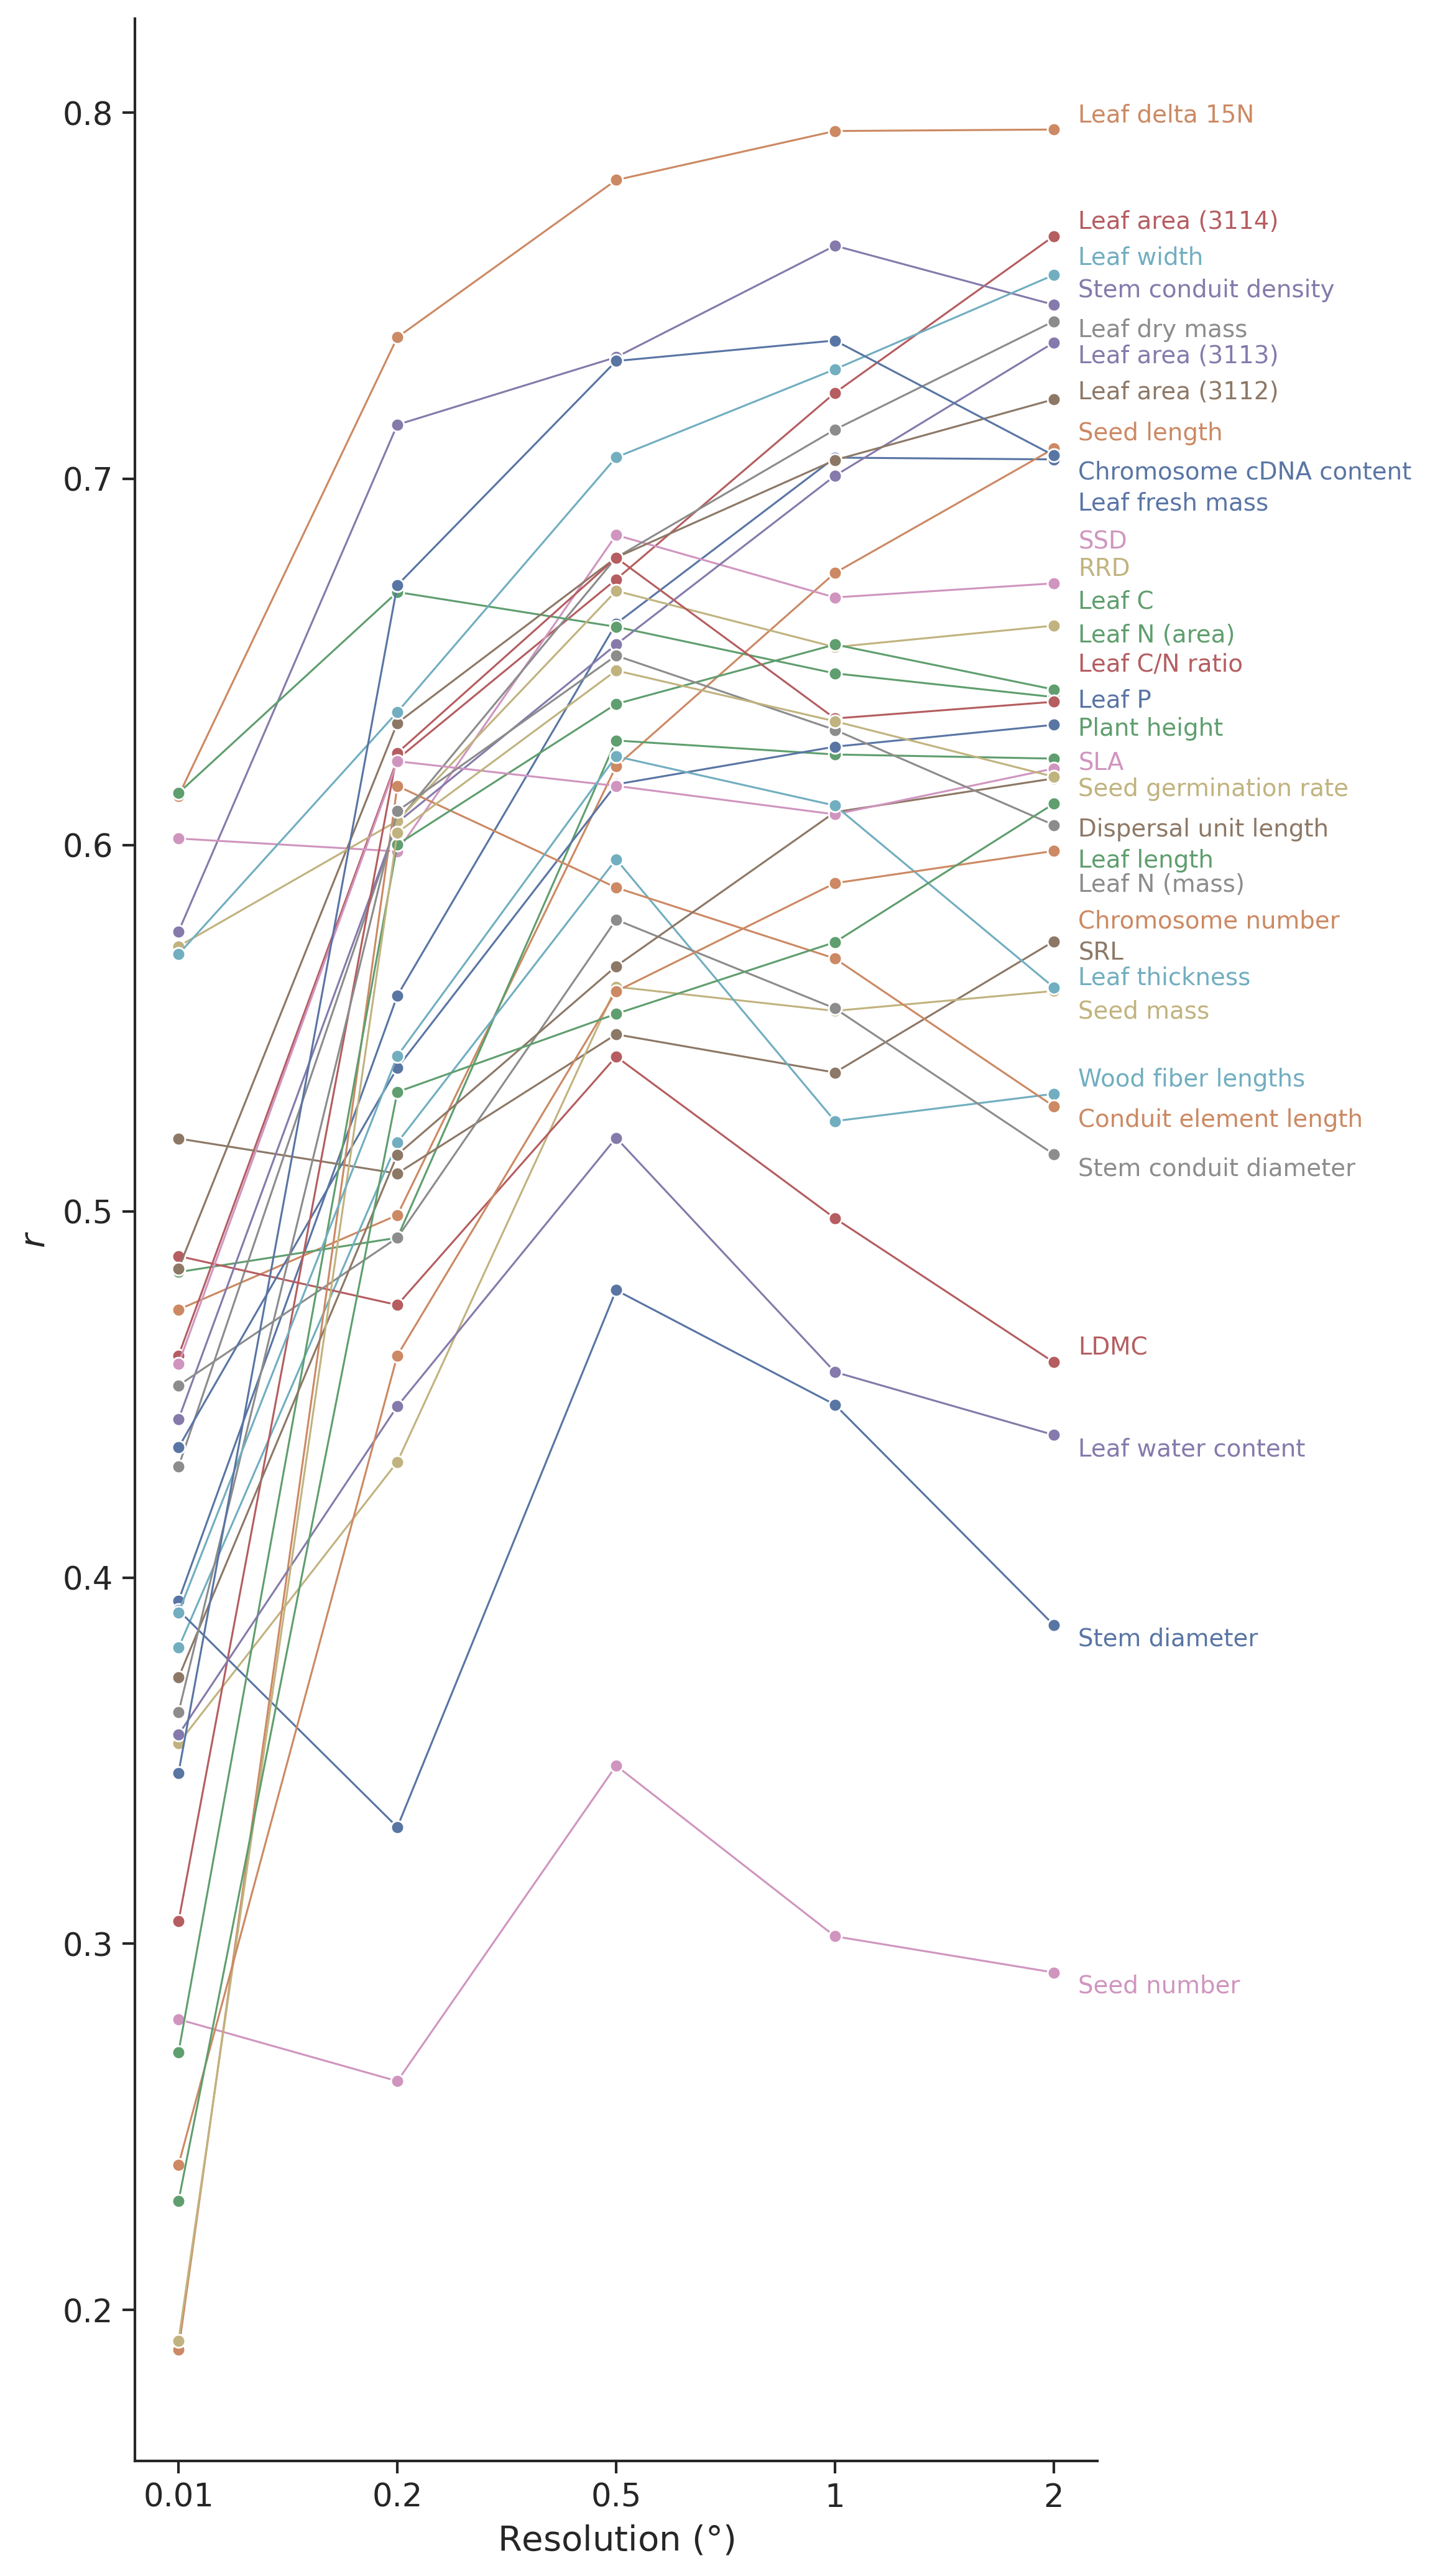

In [ ]:
out_path = Path("results/figures/pearsonr_multires_COMB.png")
with sns.plotting_context("paper", font_scale=1.4):
    plot_splot_correlations(all_results, "Shrub_Tree_Grass", ["COMB"], out_path)

### Show trait changes with decreasing resolution.


In [ ]:
data = all_results.query(
    "transform == 'none' and trait_set == 'splot_gbif' and resolution != '1km'"
)[["trait_name", "pearsonr_wt", "resolution"]].pivot(
    index="trait_name", columns="resolution", values="pearsonr_wt"
)


def color_cells(val, prev_val):
    if val > prev_val:
        color = "background-color: green; color: white"
    elif val < prev_val:
        color = "background-color: red; color: white"
    else:
        color = ""
    return color


data_styled = data.style.apply(
    lambda x: [
        color_cells(x.iloc[i], x.iloc[i - 1]) if i > 0 else "" for i in range(len(x))
    ],
    axis=1,
)
print(
    "Trait performance compared to the next highest resolution\n(green = increase from previous resolution, red = decrease):"
)
data_styled

Trait performance compared to the next highest resolution
(green = increase from previous resolution, red = decrease):


Max $r$ across all resolutions.


In [59]:
data.style.highlight_max(axis=0)